# Environmental API JSON data SPARK example
## Reading data from an IoT Photon board with BME680 sensor
We have an environmental sensor running in an office at Cranfield, generating data which is logged in the platform Thingspeak (https://thingspeak.com). Thingspeak provides an API to access the data with a range of REST endpoints. Here we are using one that returns a number of the records recorded by the sensor. The number of items is specifid by the parameter "results=", thus "results=20" returns the previous 20 rows of data before the current time. In running the code, the more data that is accessed, note the slower this will run.
Here we will load the JSON data up and then generate some descriptive statistics for it, and some charts.


# Useful links
## Data source
https://thingspeak.com/channels/783513/api_keys

## Programming
https://dev.to/wachuka_james/building-a-weather-data-pipeline-with-pyspark-prefect-and-google-cloud-19k8
https://phoenixnap.com/kb/spark-streaming

# Install PySpark and dependencies

Unlike running the PySpark notebook on Azure, PySpark is not included by default in the CoLab notebook - so we can add that next.

In [1]:
%%capture
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Spark.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!ls

In [2]:
# Initialize findspark
import findspark
findspark.init()

# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession \
     .builder \
     .appName("environmentalData") \
     .master("local[*]") \
     .getOrCreate()

spark

# Load data from the API
The data is retrieved as a JSON string that is processed into a SPARK df.

In [3]:
# Define the Sensor API URL
api_url = "https://api.thingspeak.com/channels/760368/feeds.json?minutes=1440&average=60"

# Note, this is example of the formatted JSON return string

# {
#   "channel": {
#     "id": 760368,
#     "name": "B53",
#     "description": "Test IoT application",
#     "latitude": "52.072865",
#     "longitude": "-0.630058",
#     "field1": "Temperature",
#     "field2": "Humidity",
#     "field3": "Dew_point",
#     "field4": "Heat_Index",
#     "created_at": "2019-04-16T21:03:44Z",
#     "updated_at": "2024-05-25T10:50:05Z",
#     "last_entry_id": 4145365
#   },
#   "feeds": [
#     {
#       "created_at": "2024-05-27T08:00:00Z",
#       "field1": "24.045454545454547",
#       "field2": "35.63636363636363",
#       "field3": "7.887987090909093",
#       "field4": "25.215223909090913"
#     },
#     {
#       "created_at": "2024-05-27T09:00:00Z",
#       "field1": "24.08910891089109",
#       "field2": "35.554455445544555",
#       "field3": "7.892185683168321",
#       "field4": "25.228542009900963"
#     }
#   ]
# }

In [6]:
# Define a function to fetch environmental data and return a Spark dataframe
from pyspark.sql.types import *
import json
import requests
import datetime

# define a function to process the API data and return a populated SPARK df
def fetch_environmental_data():
    # Query API URI
    response = requests.get(api_url)
    # Parse the response
    data = response.json()
    #print("Raw JSON data: ",data)

    # Extract the relevant data from the API response
    # field names
    field1_name = data["channel"]["field1"]
    field2_name = data["channel"]["field2"]
    field3_name = data["channel"]["field3"]
    field4_name = data["channel"]["field4"]

    # create df
    schema = StructType([
        StructField("created_at", DateType(), True),
        StructField(field1_name, FloatType(), True),
        StructField(field2_name, FloatType(), True),
        StructField(field3_name, FloatType(), True),
        StructField(field4_name, FloatType(), True)
    ])
    df = spark.createDataFrame([],schema)

    # create df
    schema = StructType([
        StructField("created_at", TimestampType(), True),
        StructField(field1_name, FloatType(), True),
        StructField(field2_name, FloatType(), True),
        StructField(field3_name, FloatType(), True),
        StructField(field4_name, FloatType(), True)
    ])
    # We create an empty df with the correct structure, ready to receive the data
    # This strategy is in part necessitated by the structure of the JSON
    df = spark.createDataFrame([],schema)

    # Now fetch all nested JSON field values and successively append to the df
    for items in data["feeds"]:
        #print(items)
        newRow = spark.createDataFrame([(
            datetime.datetime.strptime(items["created_at"],"%Y-%m-%dT%H:%M:%SZ"),
            float(items["field1"] or 0),
            float(items["field2"] or 0),
            float(items["field3"] or 0),
            float(items["field4"] or 0)
            )], schema)
        df = df.union(newRow) # df is immutable, so has to be appended like this
    #print(df.count())
    return df

In [7]:
environmental_df = None
environmental_df = fetch_environmental_data() # run the function above and retrieve JSON data

print(environmental_df.show())  # print out the df
print(environmental_df.count()) # the count, check the number here is the same as the URL parameter
print(environmental_df.columns) # show columns
print(environmental_df.dtypes)  # show schema

+-------------------+-----------+---------+---------+----------+
|         created_at|Temperature| Humidity|Dew_point|Heat_Index|
+-------------------+-----------+---------+---------+----------+
|2024-05-27 08:00:00|   24.09091|35.636364|7.9279084| 25.231634|
|2024-05-27 09:00:00|   24.08911|35.554455|7.8921857| 25.228542|
|2024-05-27 10:00:00|  24.990099|34.534653| 8.255714|  25.52295|
|2024-05-27 11:00:00|       25.0|34.598038| 8.291484| 25.528526|
|2024-05-27 12:00:00|       25.0| 34.60784| 8.295671| 25.528837|
|2024-05-27 13:00:00|  25.009901|34.544556| 8.277301| 25.531572|
|2024-05-27 14:00:00|  25.712872|34.524754| 8.884887| 25.869873|
|2024-05-27 15:00:00|       26.0| 34.49505| 9.123808| 26.005648|
|2024-05-27 16:00:00|  25.831684| 34.51485|  8.98481| 25.925476|
|2024-05-27 17:00:00|      25.08|    34.57| 8.349609| 25.567247|
|2024-05-27 18:00:00|       25.0|34.524754| 8.260181|  25.52621|
|2024-05-27 19:00:00|       25.0| 34.49505| 8.247495| 25.525272|
|2024-05-27 20:00:00|    

# Do some analyses
## Look at basic statistics on the df



   First we will convert the Spark df to a Pandas df and generate descriptive statistics.
   
   Next, we will convert the Spark df to an RDD and use the SparkML library to describe it - the first steps in a wider machine learning approach with SparkML.

In [8]:
import pyspark.mllib.stat as st
import numpy as np
from pyspark.sql.functions import date_format # need this for the date conversions needed

envdata = environmental_df.withColumn("created_at", date_format("created_at", "yyyy-MM-dd HH:mm:ss")).toPandas()
print(envdata.describe()) # the pandas describe() descriptive statistics

# now convert the Spark df to an rdd ready for SparkML use
rdd=environmental_df.select("Temperature", "Humidity", "Dew_point", "Heat_Index").rdd.map(lambda row: [e for e in row])
# print out the rdd to check
print(rdd.collect())

# Compute column summary statistics.
mllib_stats = st.Statistics.colStats(rdd)

print('Reading\t\tMean\tVariance')
for col, m, v in zip(["Temperature", "Humidity", "Dew_point", "Heat_Index"],
                     mllib_stats.mean(),
                     mllib_stats.variance()):
    print('{0}: \t{1:.2f} \t {2:.2f}'.format(col, m, np.sqrt(v)))

       Temperature   Humidity  Dew_point  Heat_Index
count    25.000000  25.000000  25.000000   25.000000
mean     24.322670  34.956253   7.846810   25.336897
std       0.946584   0.401078   0.699322    0.316221
min      23.000000  34.464645   6.778660   24.946215
25%      23.702971  34.534653   7.417869   25.115871
50%      24.090910  35.176472   7.892186   25.231634
75%      25.000000  35.294117   8.277301   25.528526
max      26.000000  35.636364   9.123808   26.005648
[[24.090909957885742, 35.6363639831543, 7.927908420562744, 25.23163414001465], [24.089109420776367, 35.5544548034668, 7.892185688018799, 25.22854232788086], [24.99009895324707, 34.53465270996094, 8.255714416503906, 25.52294921875], [25.0, 34.59803771972656, 8.291483879089355, 25.528526306152344], [25.0, 34.60784149169922, 8.295671463012695, 25.528837203979492], [25.00990104675293, 34.5445556640625, 8.277300834655762, 25.531572341918945], [25.712871551513672, 34.52475357055664, 8.884886741638184, 25.869873046875], [26.

Note converting to a pandas df loads ALL the data into the memory of the head node.

# Graph data
## Show histogram
Now take the Spark df from the JSON data and produce a histogram using matplotlib

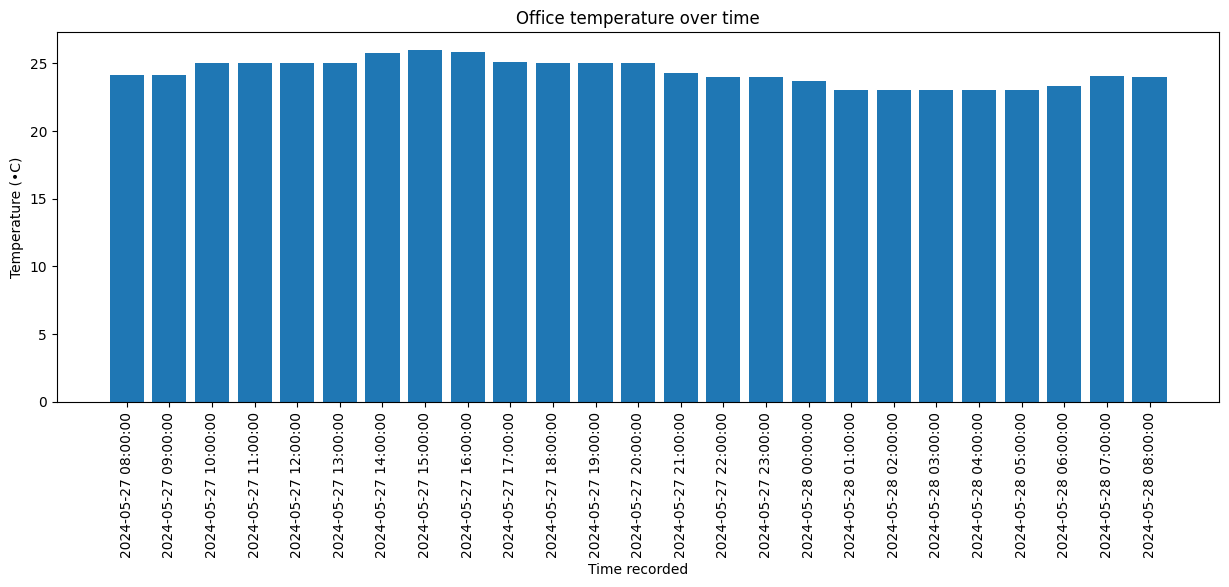

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import date_format

# Need to handle DateTime from Spark df to pandas df
envdata = environmental_df.withColumn("created_at", date_format("created_at", "yyyy-MM-dd HH:mm:ss")).toPandas()

plt.figure(1).set_figwidth(15)
plt.title('Office temperature over time')
plt.xlabel('Time recorded')
plt.xticks(rotation=90)
plt.ylabel('Temperature (•C)')
plt.bar(envdata['created_at'], envdata['Temperature'])
plt.show()

Create another plot but this time we will use using the pandas.plot function (as opposed to directly MatPlotLib) - and also it is a line chart this time.

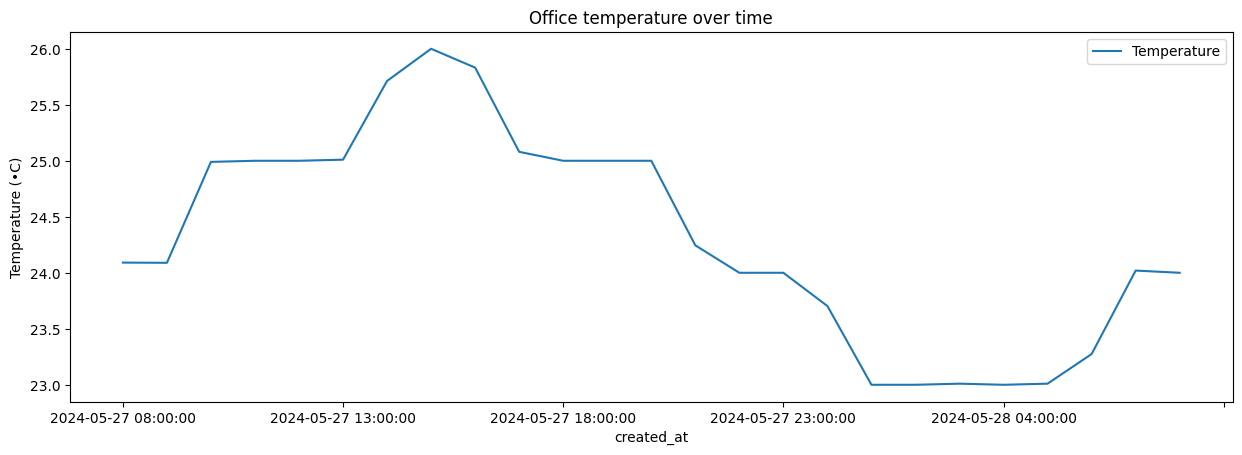

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import date_format

# Need to handle DateTime from Spark df to pandas df
envdata = environmental_df.withColumn("created_at", date_format("created_at", "yyyy-MM-dd HH:mm:ss")).toPandas()

plt.figure().set_figwidth(15)
axes = plt.axes()
plt.title('Office temperature over time')
plt.xlabel('Time recorded')
plt.ylabel('Temperature (•C)')
axes.xaxis.set_tick_params(rotation=90)
envdata.plot(x='created_at', y='Temperature', legend=True, kind='line', ax=axes)
plt.show()